In [1]:
# this is a copy of previous with a different / longer database
# this isnt working for some reason ?

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/pmc_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [11]:
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
import numpy as np
import config
import librosa
import utils as my_utils
import matplotlib.pyplot as plt
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import classifiers.classifier_base as classifier_base
import classifiers.fhmm.classifier_fhmm as classifier_fhmm
import classifiers.hmm.classifier_hmm as classifier_hmm
import processing.process_method_base as process_method_base
import processing.processing as proc
import os.path
reload(fe_base)
reload(fe_spafe)
reload(classifier_base)
reload(classifier_fhmm)
reload(classifier_hmm)
reload(process_method_base)
reload(proc)

<module 'processing.processing' from '/Users/david/Documents/mastersCode/ubm/processing/processing.py'>

In [22]:
# create ads
# female ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/FEMALE/MIC"
female_ads = myads.AudioDatastore()
female_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(female_ads.labels).values()
# male ads
datasetFolder = r"/Users/david/Documents/data/speech/ivectors/SPEECH DATA/MALE/MIC"
male_ads = myads.AudioDatastore()
male_ads.populate(datasetFolder, include_sub_folders=True, label_source=True)
Counter(male_ads.labels).values()
# combine ads
ads = myads.AudioDatastore()
ads.set([datasetFolder], files=female_ads.files + male_ads.files, labels=female_ads.labels + male_ads.labels)
# split ads
developmentLabels = ["M01", "M02", "M03", "M04", "M06", "M07", "M08", "M09", "F01", "F02", "F03", "F04", "F06", "F07",
                     "F08", "F09"]
evaluationLabels = ["M05", "M10", "F05", "F10"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
# numFilesPerSpeakerForEnrollment = 3
adsEnroll, adsTest = myads.split(adsEvaluate, 20)
adsTest, _ = myads.split(adsTest, 10)
# adsTest, adsDet = myads.split(adsDet, 2)
# #
# speedUpExamples = True
# if speedUpExamples:
#     adsTrain, _ = myads.split(adsTrain, 20)
#     adsDet, _ = myads.split(adsDet, 20)

In [14]:
import torch
torch.set_num_threads(1)
model, torch_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
(get_speech_timestamps,
 _, read_audio,
 *_) = torch_utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


In [17]:
processing = proc.Processing()
all_sounds = []

for file in adsTrain.files[0:5]:
    signal = processing.file_to_signal(file)
    signal = processing.normalize_signal(signal)
    speech_timestamps = get_speech_timestamps(signal, model, sampling_rate=config.SAMPLING_RATE)
    segments = []
    for i in range(len(speech_timestamps)):
        start = speech_timestamps[i]['start']
        end = speech_timestamps[i]['end']
        segments.append(signal[start: end])
    segments_flattened = np.array([item for sublist in segments for item in sublist])
    all_sounds.append(segments_flattened)
all_sounds = np.array([item for sublist in all_sounds for item in sublist])

0.014820646328789258

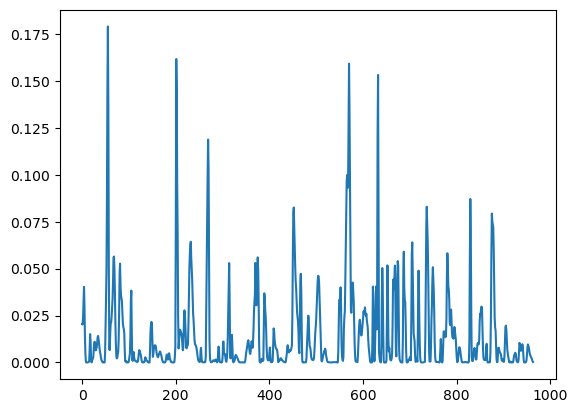

In [19]:
ap = my_utils.periodic_power(all_sounds, 500, 250)
plt.plot(ap[18:-4])
np.mean(ap[18:-4])
# 0.015

testing for  spafe.features.mfcc.mfcc


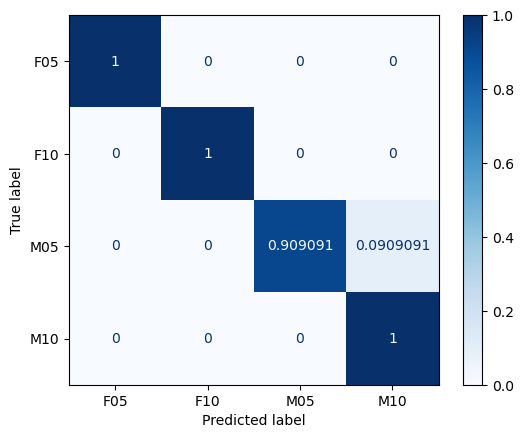

testing for  spafe.features.mfcc.mfcc


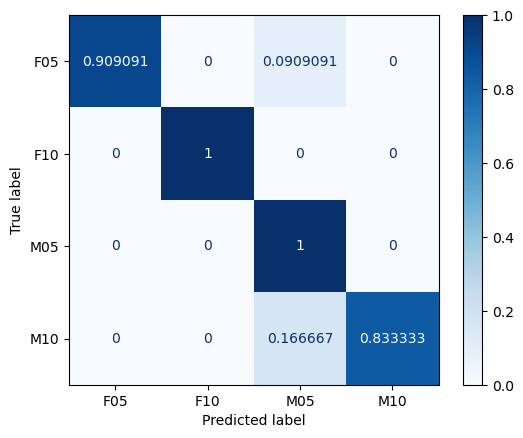

testing for  spafe.features.mfcc.mfcc


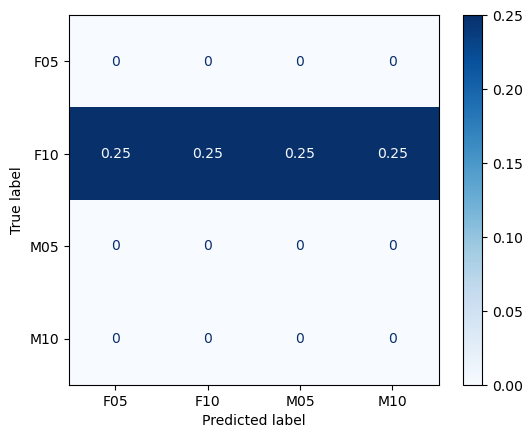

testing for  spafe.features.mfcc.mfcc


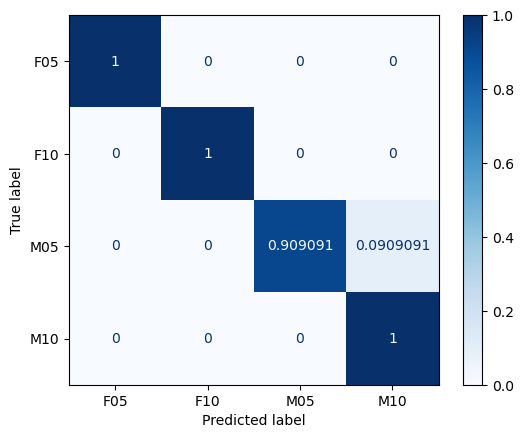

testing for  spafe.features.mfcc.mfcc


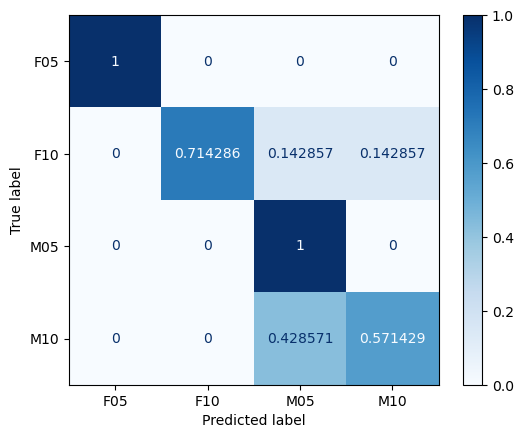

testing for  spafe.features.mfcc.mfcc


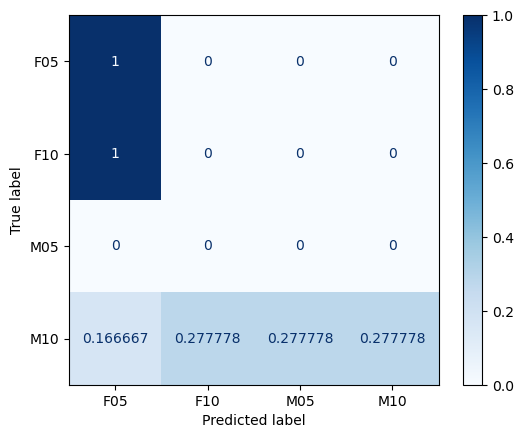

In [24]:
process_methods = [
    process_method_base.ProcessMethodBase(snr_db=40, reverb=False, signal_average_power=0.025,
                                          model=model, get_speech_timestamps=get_speech_timestamps
                                          ),
    process_method_base.ProcessMethodBase(snr_db=20, reverb=False, signal_average_power=0.025,
                                          model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=10, reverb=False, signal_average_power=0.025,
                                          model=model, get_speech_timestamps=get_speech_timestamps),
    # process_method_base.ProcessMethodBase(snr_db=10, reverb=False),
    # process_method_base.ProcessMethodBase(snr_db=10, reverb=False),
    # process_method_base.ProcessMethodBase(snr_db=10, reverb=False),
    # process_method_base.ProcessMethodBase(snr_db=10, reverb=False),

]

fe_methods = [
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafe(fe_spafe.GFCC),
    # fe_spafe.FeatureExtractorSpafeDelta(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafeDelta(fe_spafe.GFCC),
    # fe_spafe.FeatureExtractorSpafeDeltaDeltas(fe_spafe.MFCC),
    # fe_spafe.FeatureExtractorSpafeDeltaDeltas(fe_spafe.GFCC),
]

classifiers = {}
for i in range(len(fe_methods)):
    classifier = classifier_hmm.ClassifierHMM(fe_methods[i], process_methods[i])
    # classifier.set_normalisation(ads)
    classifier.train(adsEnroll)
    classifier.test(adsTest)

for i in range(len(fe_methods)):
    classifier = classifier_fhmm.ClassifierFHMM(fe_methods[i], process_methods[i])
    # classifier.set_normalisation(adsNorm)
    classifier.train(adsEnroll)
    classifier.train_noise_hmm()
    classifier.adapt_speaker_models()
    classifier.test(adsTest)